In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr


In [2]:
#Inflate predictions

def inflate_predictions(ref_alt, model_dirs=['models'], model_ctx='CXCL2', fold_index=[0], fold_suffixes=[''], shift_suffixes=['']) :

    print("Inflating predictions.")
    
    df_folds = []
    
    scores = []

    for model_dir in model_dirs :
        for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

            print("fold_ix = " + str(fold_ix))
            
            shift_scores = []
            
            for shift_suffix in shift_suffixes :

                sed = h5py.File(model_dir + '/f' + str(fold_ix) + 'c0' + fold_suffix + '/mpra_siegel_beas2b_all_' + model_ctx + shift_suffix + '_pad_' + ref_alt + '/sed.h5', 'r')

                score_mat = sed['logSED'][()].astype('float32')
                shift_scores.append(score_mat.copy()[..., None])
                
                if shift_suffix == '' :
                    gene_id_mat = sed['gene'][()]
                    si_mat = sed['si'][()]
                    ci_mat = sed['ci'][()]
                    seq_id_mat = sed['seq_id'][()]
                    ctx_id_mat = sed['ctx_id'][()]

                    gene_ids = []
                    seq_ids = []
                    ctx_ids = []

                    for i, [si, ci] in enumerate(zip(si_mat.tolist(), ci_mat.tolist())) :

                        gene_ids.append(gene_id_mat[i].decode())
                        seq_ids.append(seq_id_mat[si].decode())
                        ctx_ids.append(ctx_id_mat[ci].decode())

                    df = pd.DataFrame({
                        'gene_id' : gene_ids,
                        'seq_id' : seq_ids,
                        'ctx_id' : ctx_ids,
                    })

                    df_folds.append(df)
            
            scores.append(np.mean(np.concatenate(shift_scores, axis=-1), axis=-1)[..., None])

    df = df_folds[0]
    
    scores = np.concatenate(scores, axis=-1)
    
    df['row_index'] = np.arange(len(df), dtype='int32')
    
    #Get context genes
    ctx_df = pd.read_csv('contexts_' + model_ctx + '_with_gene.tsv', sep='\t')
    ctx_df['row_id'] = ctx_df['chrom'].astype(str) + '_' + ctx_df['start'].astype(str) + '_' + ctx_df['end'].astype(str) + '_' + ctx_df['gene_id'].astype(str)
    
    df['gene_base'] = df['gene_id'].apply(lambda x: x.split(".")[0] if "." in x else x)
    df['row_id'] = df['ctx_id'].astype(str) + '_' + df['gene_base'].astype(str)
    
    df = df.join(ctx_df[['row_id']].set_index('row_id'), on='row_id', how='inner').copy().reset_index(drop=True)
    
    scores = scores[df['row_index'].values.tolist(), :]
    
    df['row_index'] = np.arange(len(df), dtype='int32')
    
    #scores = scores.astype('float16')
    
    return df, scores

df, scores_1_ref = inflate_predictions('ref', ['models', 'models_retry1', 'models_retry2'], 'CXCL2', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_2_ref = inflate_predictions('ref', ['models', 'models_retry1', 'models_retry2'], 'CXCL2_2', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_3_ref = inflate_predictions('ref', ['models', 'models_retry1', 'models_retry2'], 'TUBGCP3', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_4_ref = inflate_predictions('ref', ['models', 'models_retry1', 'models_retry2'], 'PPIF', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_5_ref = inflate_predictions('ref', ['models', 'models_retry1', 'models_retry2'], 'SDF4', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_6_ref = inflate_predictions('ref', ['models', 'models_retry1', 'models_retry2'], 'AGTRAP', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])

_, scores_1_alt = inflate_predictions('alt', ['models', 'models_retry1', 'models_retry2'], 'CXCL2', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_2_alt = inflate_predictions('alt', ['models', 'models_retry1', 'models_retry2'], 'CXCL2_2', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_3_alt = inflate_predictions('alt', ['models', 'models_retry1', 'models_retry2'], 'TUBGCP3', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_4_alt = inflate_predictions('alt', ['models', 'models_retry1', 'models_retry2'], 'PPIF', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_5_alt = inflate_predictions('alt', ['models', 'models_retry1', 'models_retry2'], 'SDF4', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])
_, scores_6_alt = inflate_predictions('alt', ['models', 'models_retry1', 'models_retry2'], 'AGTRAP', [0, 1], ['', ''], ['', '_shift_-112', '_shift_-24', '_shift_112', '_shift_24'])

scores_ref = np.concatenate([scores_1_ref[..., None], scores_2_ref[..., None], scores_3_ref[..., None], scores_4_ref[..., None], scores_5_ref[..., None], scores_6_ref[..., None]], axis=-1)
scores_alt = np.concatenate([scores_1_alt[..., None], scores_2_alt[..., None], scores_3_alt[..., None], scores_4_alt[..., None], scores_5_alt[..., None], scores_6_alt[..., None]], axis=-1)

print("len(df) = " + str(len(df)))
print("scores_ref.shape = " + str(scores_ref.shape))
print("scores_alt.shape = " + str(scores_alt.shape))


Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
fold_ix = 0
fold_ix = 1
Inflating predictions.
fold_ix = 0
fold_ix = 1
fol

In [3]:
#Get target names

target_ids = h5py.File('models/f0c0/mpra_siegel_beas2b_all_CXCL2_ref/sed.h5', 'r')['target_ids'][()]
target_ids = [tid.decode() for tid in target_ids.tolist()]

target_name_dict = pd.read_csv('targets_human_rna.txt', sep='\t')[['identifier', 'description']].set_index('identifier').to_dict(orient='index')

target_names = []
for tid in target_ids :
    target_names.append(target_name_dict[tid]['description'])


In [4]:
#Load MPRA measurements

mpra_df = pd.read_csv('/home/jlinder/seqnn/data/mpra_siegel/mpra_siegel_beas2b_all.csv', sep='\t')

print("len(mpra_df) = " + str(len(mpra_df)))


len(mpra_df) = 2085


In [5]:
#Join against predictions

df = df.join(mpra_df.set_index('seq_id'), on='seq_id', how='inner').copy().reset_index(drop=True)

scores_ref = scores_ref[df['row_index'].values.tolist(), :]
scores_alt = scores_alt[df['row_index'].values.tolist(), :]


In [6]:
#Aggregate and store cell type-matched predictions

tissue_names = [
    'hek293',
    'k562',
    'hepg2',
    'gm12878',
    'jurkat',
    
    'jurkat_total',
    'jurkat_4su',
    
    'hela_actd_0h',
    'hela_actd_3h',
    'hela_actd_6h',
    
    'k562_actd_0h',
    'k562_actd_0.5h',
    'k562_actd_2h',
    'k562_actd_4h',
    'k562_actd_8h',
    
    'hues9_actd_0h',
    'hues9_actd_0.5h',
    'hues9_actd_2h',
    'hues9_actd_4h',
    'hues9_actd_8h',
    
    'hek293_4su_1h',
    'hek293_4su_2h',
    'hek293_4su_4h',
    'hek293_4su_8h',
    'hek293_4su_12h',
    'hek293_4su_24h',
    'hek293_4su_SS',
    
    'hek293_actd_nt',
    'hek293_actd_actd',
    
    'hek293t_act_0h',
    'hek293t_act_1h_ad',
    'hek293t_act_3h_ad',
    'hek293t_act_6h_ad',
    
    'lcl_total',
    'lcl_4su_30',
    'lcl_4su_60',
]

tissues_regexps = [
    'RNA:4sU:HEK293 total RNA|RNA:ActD:HEK293T Control for DCP2 knockout|RNA:ActD:HEK293T half-life measurement by transcriptional inhibition ctrl_nt_|RNA:4sU:HEK293_SS_R1|RNA:ActD:HEK293T 293t_0h_',
    'RNA:K562$',
    'RNA:HepG2$',
    'RNA:GM12878$',
    'RNA:Jurkat, Clone E6-1$',
    
    'RNA:4sU:Jurkat total RNA',
    'RNA:4sU:Jurkat 4sU-labeled RNA',
    
    'RNA:ActD:HeLa mRNA lifetime-SiControl-TI-0h D1',
    'RNA:ActD:HeLa mRNA lifetime-SiControl-TI-3h D2',
    'RNA:ActD:HeLa mRNA lifetime-SiControl-TI-6h D3',
    
    'RNA:ActD:K562__0\.0h__rep.',
    'RNA:ActD:K562__0\.5h__rep.',
    'RNA:ActD:K562__2h__rep.',
    'RNA:ActD:K562__4h__rep.',
    'RNA:ActD:K562__8h__rep.',
    
    'RNA:ActD:HUES9__0\.0h__rep.',
    'RNA:ActD:HUES9__0\.5h__rep.',
    'RNA:ActD:HUES9__2h__rep.',
    'RNA:ActD:HUES9__4h__rep.',
    'RNA:ActD:HUES9__8h__rep.',
    
    'RNA:4sU:HEK293_1h_R1',
    'RNA:4sU:HEK293_2h_R1',
    'RNA:4sU:HEK293_4h_R1',
    'RNA:4sU:HEK293_8h_R1',
    'RNA:4sU:HEK293_12h_R1',
    'RNA:4sU:HEK293_24h_R1',
    'RNA:4sU:HEK293_SS_R1',
    
    'RNA:ActD:HEK293T half-life measurement by transcriptional inhibition ctrl_nt_.*',
    'RNA:ActD:HEK293T half-life measurement by transcriptional inhibition ctrl_actD_.*',
    
    'RNA:ActD:HEK293T 293t_0h_.*',
    'RNA:ActD:HEK293T 293t_1h_ad_.*',
    'RNA:ActD:HEK293T 293t_3h_ad_.*',
    'RNA:ActD:HEK293T 293t_6h_ad_.*',
    
    'RNA:HapMap LCL RNA-seq of YRI individual.*',
    'RNA:4sU:HapMap LCL 4sU-seq of YRI individual.*-30-.*',
    'RNA:4sU:HapMap LCL 4sU-seq of YRI individual.*-60-.*',
]

targets_df = pd.DataFrame({
    'description' : target_names
})

for tissue_name, filter_query in zip(tissue_names, tissues_regexps) :

    for ctx_i, ctx in enumerate(['CXCL2', 'CXCL2_2', 'TUBGCP3', 'PPIF', 'SDF4', 'AGTRAP']) :
    
        target_index = targets_df.loc[targets_df['description'].str.contains(filter_query)].index.values.tolist()

        df['borzoi_' + tissue_name + '_' + ctx] = np.mean(np.mean(scores_alt[..., ctx_i] - scores_ref[..., ctx_i], axis=-1)[:, target_index], axis=-1)
        df['borzoi_' + tissue_name + '_ref' + '_' + ctx] = np.mean(np.mean(scores_ref[..., ctx_i], axis=-1)[:, target_index], axis=-1)

        df = df.copy()


In [7]:
#Clean consequence columns

df.loc[df['overlap_with_snp'].isnull(), 'overlap_with_snp'] = 'no_snp'
df.loc[df['hap'].isnull(), 'hap'] = 'no_hap'


lr.coef_ = [ 3.1731213e+01  4.2809954e+00  6.2717509e-01 -8.4691085e-03
 -2.0251994e+00  9.2833071e+00 -8.6988010e+00  8.2161993e-01
 -6.8267006e-01 -7.2438163e-01]
650
SpearmanrResult(correlation=0.5454459154841879, pvalue=1.171729639993994e-51)
PearsonRResult(statistic=0.541326387765686, pvalue=9.246984976723499e-51)


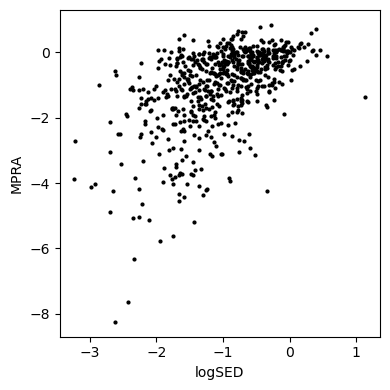

lr.coef_ = [ 20.877394    -3.01508      0.6003282    0.4561363   -0.17979509
  -1.8298599    2.0632799    1.4394637   15.2324095  -16.113224  ]
650
SpearmanrResult(correlation=0.5301467972175096, pvalue=2.1835838556389298e-48)
PearsonRResult(statistic=0.506642625267109, pvalue=1.119584421566648e-43)


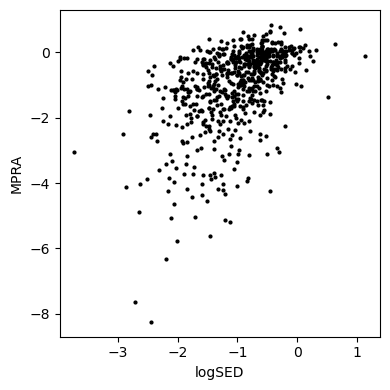

lr.coef_ = [ 21.978813    4.7786183 -11.198982   15.121318   -1.4599802  12.937783
 -12.024246   16.11348    -7.709053   17.039364 ]
650
SpearmanrResult(correlation=0.5419771480569732, pvalue=6.684968581299195e-51)
PearsonRResult(statistic=0.528894474475161, pvalue=3.9766923539331604e-48)


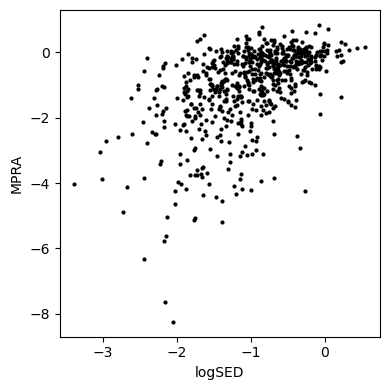

lr.coef_ = [ 7.6171436 -9.277067   1.5274943 26.115705  -1.833107   6.6312766
 -1.3305179 -1.8869555  0.8481109  5.379901 ]
650
SpearmanrResult(correlation=0.5839744727661622, pvalue=1.1005066046427045e-60)
PearsonRResult(statistic=0.5677242320054049, pvalue=9.870883978962416e-57)


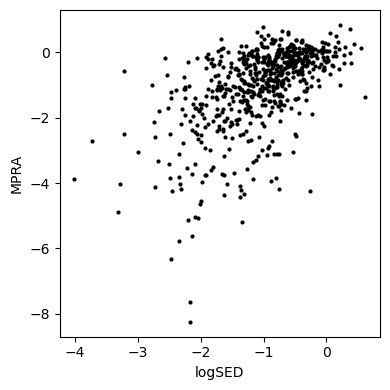

lr.coef_ = [ -3.1014297    6.4227138   -8.422168     0.81687176  -0.9826181
   9.412424    -5.8842783   14.847712   -11.050206     3.7745862 ]
650
SpearmanrResult(correlation=0.5557348501689672, pvalue=5.927215260542138e-54)
PearsonRResult(statistic=0.5305183636796624, pvalue=1.8268932884712065e-48)


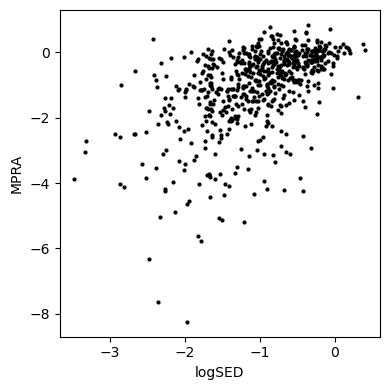

lr.coef_ = [ 4.2244577  -1.2128407   2.544197    5.6239843   2.0287287   2.5934148
 -2.3279579   3.2353017  -0.80070853  8.599449  ]
650
SpearmanrResult(correlation=0.5463700432973261, pvalue=7.342636532923473e-52)
PearsonRResult(statistic=0.5199792055312689, pvalue=2.6416083061100218e-46)


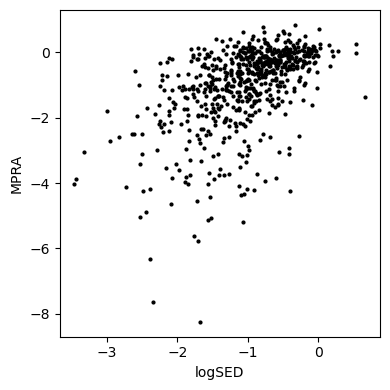

In [8]:
#Fit regression model(s): One model per marginalization context

from sklearn.linear_model import Ridge

df_sub = df.loc[
    (np.sign(df['effect_size_T0']) == np.sign(df['effect_size_T4T0']))
    & (~df['seq'].str.contains("AATAAA|ATTAAA"))
    & (~df['hap'].str.contains("miRNA|CDE"))
].drop_duplicates(subset=['seq_ctrl'], keep='first').copy().reset_index(drop=True)

lrs = []
for ctx_i, ctx in enumerate(['CXCL2', 'CXCL2_2', 'TUBGCP3', 'PPIF', 'SDF4', 'AGTRAP']) :
    col_names = [
        'borzoi_hek293_ref_' + ctx,
        'borzoi_k562_ref_' + ctx,
        'borzoi_hepg2_ref_' + ctx,
        'borzoi_gm12878_ref_' + ctx,
        'borzoi_jurkat_ref_' + ctx,

        'borzoi_jurkat_total_ref_' + ctx,
        'borzoi_jurkat_4su_ref_' + ctx,

        'borzoi_hela_actd_0h_ref_' + ctx,
        'borzoi_hela_actd_3h_ref_' + ctx,
        'borzoi_hela_actd_6h_ref_' + ctx,

        'borzoi_k562_actd_0h_ref_' + ctx,
        'borzoi_k562_actd_0.5h_ref_' + ctx,
        'borzoi_k562_actd_2h_ref_' + ctx,
        'borzoi_k562_actd_4h_ref_' + ctx,
        'borzoi_k562_actd_8h_ref_' + ctx,

        'borzoi_hues9_actd_0h_ref_' + ctx,
        'borzoi_hues9_actd_0.5h_ref_' + ctx,
        'borzoi_hues9_actd_2h_ref_' + ctx,
        'borzoi_hues9_actd_4h_ref_' + ctx,
        'borzoi_hues9_actd_8h_ref_' + ctx,

        'borzoi_hek293_4su_1h_ref_' + ctx,
        'borzoi_hek293_4su_2h_ref_' + ctx,
        'borzoi_hek293_4su_4h_ref_' + ctx,
        'borzoi_hek293_4su_8h_ref_' + ctx,
        'borzoi_hek293_4su_12h_ref_' + ctx,
        'borzoi_hek293_4su_24h_ref_' + ctx,
        'borzoi_hek293_4su_SS_ref_' + ctx,

        'borzoi_hek293_actd_nt_ref_' + ctx,
        'borzoi_hek293_actd_actd_ref_' + ctx,

        'borzoi_hek293t_act_0h_ref_' + ctx,
        'borzoi_hek293t_act_1h_ad_ref_' + ctx,
        'borzoi_hek293t_act_3h_ad_ref_' + ctx,
        'borzoi_hek293t_act_6h_ad_ref_' + ctx,

        'borzoi_lcl_total_ref_' + ctx,
        'borzoi_lcl_4su_30_ref_' + ctx,
        'borzoi_lcl_4su_60_ref_' + ctx,
    ]

    pred_vals = df_sub[col_names].values.copy()

    meas = np.log2(df_sub['ratios_T4T0_ctrl'].values / (1. - df_sub['ratios_T4T0_ctrl'].values))

    lr = Ridge(alpha=0.002)
    _ = lr.fit(pred_vals, meas)

    lrs.append(lr)
    
    meas_pred = lr.predict(pred_vals)

    print("lr.coef_ = " + str(lr.coef_[:10]))
    
    print(len(df_sub))
    print(spearmanr(meas_pred, meas))
    print(pearsonr(meas_pred, meas))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(meas_pred, meas, color='black', s=4)

    plt.xlabel("logSED")
    plt.ylabel("MPRA")

    plt.tight_layout()

    plt.show()


In [9]:
#Apply regression model(s) to variants

df_sub = df.loc[
    (np.sign(df['effect_size_T0']) == np.sign(df['effect_size_T4T0']))
    & (~df['seq'].str.contains("AATAAA|ATTAAA"))
    & (~df['hap'].str.contains("miRNA|CDE"))
].copy().reset_index(drop=True)

meas_preds = []
for ctx_i, ctx in enumerate(['CXCL2', 'CXCL2_2', 'TUBGCP3', 'PPIF', 'SDF4', 'AGTRAP']) :
    col_names = [
        'borzoi_hek293_' + ctx,
        'borzoi_k562_' + ctx,
        'borzoi_hepg2_' + ctx,
        'borzoi_gm12878_' + ctx,
        'borzoi_jurkat_' + ctx,

        'borzoi_jurkat_total_' + ctx,
        'borzoi_jurkat_4su_' + ctx,

        'borzoi_hela_actd_0h_' + ctx,
        'borzoi_hela_actd_3h_' + ctx,
        'borzoi_hela_actd_6h_' + ctx,

        'borzoi_k562_actd_0h_' + ctx,
        'borzoi_k562_actd_0.5h_' + ctx,
        'borzoi_k562_actd_2h_' + ctx,
        'borzoi_k562_actd_4h_' + ctx,
        'borzoi_k562_actd_8h_' + ctx,

        'borzoi_hues9_actd_0h_' + ctx,
        'borzoi_hues9_actd_0.5h_' + ctx,
        'borzoi_hues9_actd_2h_' + ctx,
        'borzoi_hues9_actd_4h_' + ctx,
        'borzoi_hues9_actd_8h_' + ctx,

        'borzoi_hek293_4su_1h_' + ctx,
        'borzoi_hek293_4su_2h_' + ctx,
        'borzoi_hek293_4su_4h_' + ctx,
        'borzoi_hek293_4su_8h_' + ctx,
        'borzoi_hek293_4su_12h_' + ctx,
        'borzoi_hek293_4su_24h_' + ctx,
        'borzoi_hek293_4su_SS_' + ctx,

        'borzoi_hek293_actd_nt_' + ctx,
        'borzoi_hek293_actd_actd_' + ctx,

        'borzoi_hek293t_act_0h_' + ctx,
        'borzoi_hek293t_act_1h_ad_' + ctx,
        'borzoi_hek293t_act_3h_ad_' + ctx,
        'borzoi_hek293t_act_6h_ad_' + ctx,

        'borzoi_lcl_total_' + ctx,
        'borzoi_lcl_4su_30_' + ctx,
        'borzoi_lcl_4su_60_' + ctx,
    ]

    pred_vals = df_sub[col_names].values.copy()

    meas_pred = lrs[ctx_i].predict(pred_vals)
    
    meas_preds.append(meas_pred[:, None])

#Average across models
df_sub['borzuki'] = np.mean(np.concatenate(meas_preds, axis=-1), axis=-1)


In [10]:
#Load and append saluki predictions

saluki_df = pd.read_csv('fastUTR_MPRA_predictions_Beas2B.txt', sep='\t')

saluki_dict = {}
for _, row in saluki_df.iterrows() :
    saluki_dict[row['seq']] = row['Prediction']

saluki_preds = []
for _, row in df_sub.iterrows() :
    saluki_preds.append(saluki_dict[row['seq']])

df_sub['saluki'] = saluki_preds


In [11]:
#Plot predictions vs measurements

from scipy.stats import gaussian_kde

save_figs = True
n_kde_sample = 500

borzuki_col = 'borzuki'
saluki_col = 'saluki'
avg_col = 'borzuki_saluki'
meas_col = 'effect_size_T4T0'

n = len(df_sub)
print("n = " + str(n))

#Calculate standardized average
saluki_std = np.std(df_sub[saluki_col].values)
saluki_mean = np.mean(df_sub[saluki_col].values)

borzoi_std = np.std(df_sub[borzuki_col].values)
borzoi_mean = np.mean(df_sub[borzuki_col].values)

df_sub[avg_col] = ((df_sub[saluki_col].values - saluki_mean) / saluki_std + (df_sub[borzuki_col].values - borzoi_mean) / borzoi_std) / 2.


n = 837


Borzuki:
Spearman R = 0.523
Pearson R  = 0.574



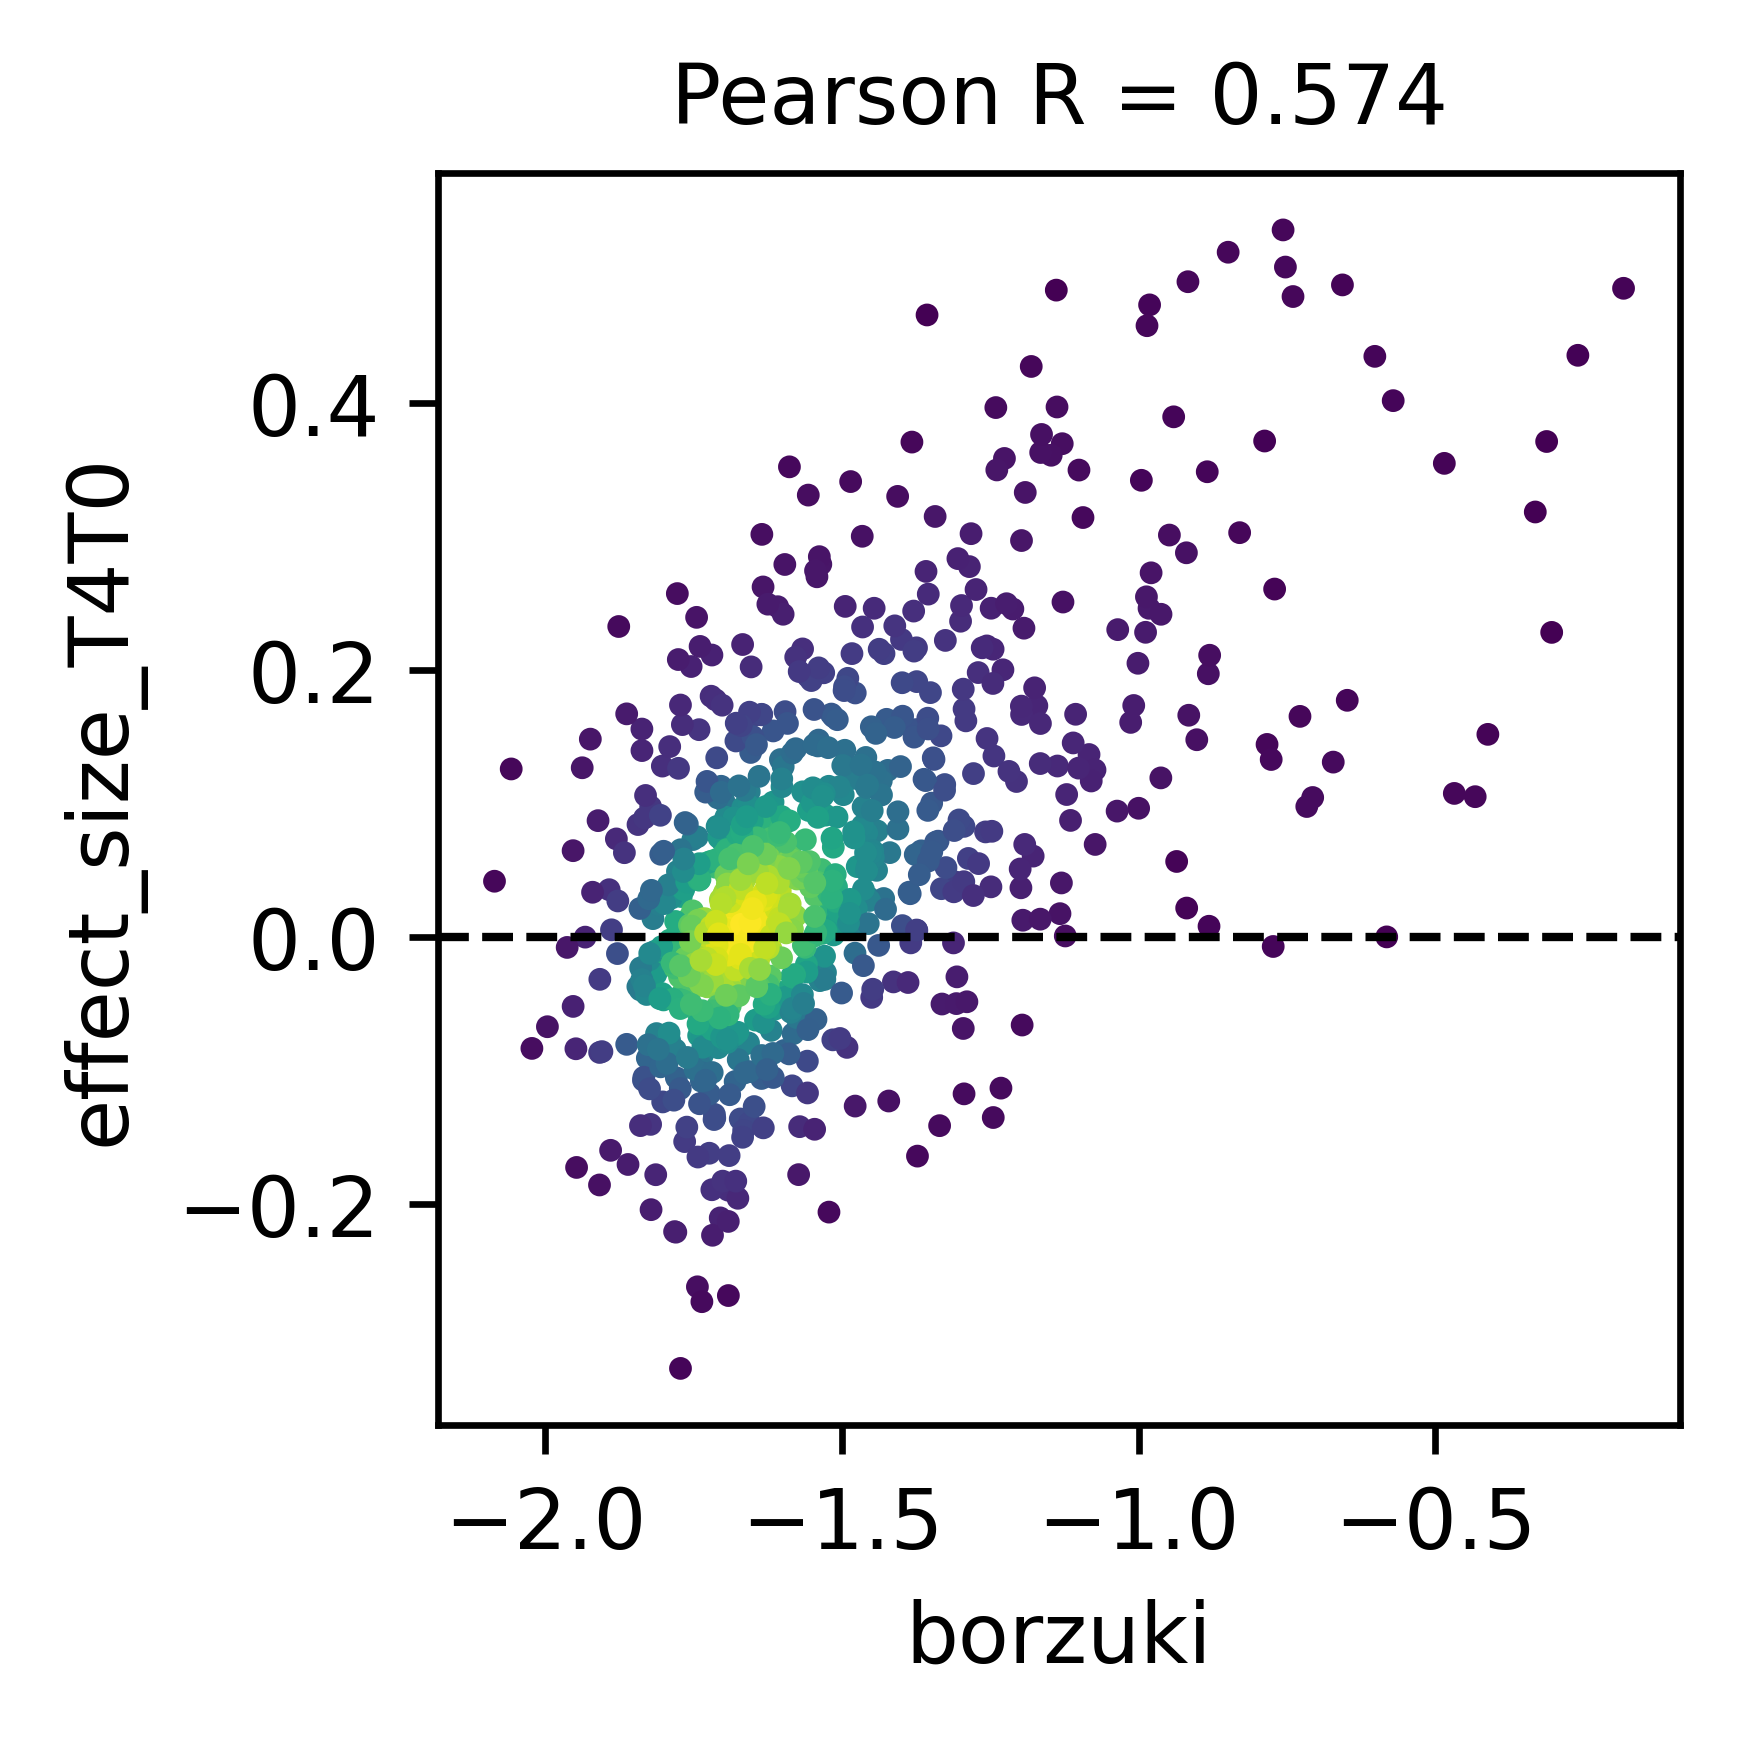

In [12]:
#Borzuki

pred_col = borzuki_col

sample_index = np.arange(n, dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

y_pred = np.array(df_sub[pred_col].values, dtype='float32')
y_true = np.array(df_sub[meas_col].values, dtype='float32')

rs_val = spearmanr(y_pred, y_true)[0]
rp_val = pearsonr(y_pred, y_true)[0]

vals = np.concatenate([
    np.copy(y_pred)[None, :],
    np.copy(y_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, _ = spearmanr(y_pred, y_true)
rp_val, _ = pearsonr(y_pred, y_true)

print("Borzuki:")
print("Spearman R = " + str(round(rs_val, 3)))
print("Pearson R  = " + str(round(rp_val, 3)))
print("")

f = plt.figure(figsize=(3, 3), dpi=600)

plt.scatter(y_pred, y_true, s=3, c=gkernel, cmap='viridis', rasterized=True)

plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks([-2.0, -1.5, -1.0, -0.5], fontsize=10)
plt.yticks([-0.2, 0.0, 0.2, 0.4], fontsize=10)

plt.xlabel(pred_col, fontsize=10)
plt.ylabel(meas_col, fontsize=10)

plt.title("Pearson R = " + str(round(rp_val, 3)), fontsize=10)

plt.tight_layout()

if save_figs :
    plt.savefig('borzuki_mpra_beas2b_bagging_6_reps.png', dpi=600)
    plt.savefig('borzuki_mpra_beas2b_bagging_6_reps.pdf')

plt.show()


Saluki:
Spearman R = 0.548
Pearson R  = 0.632



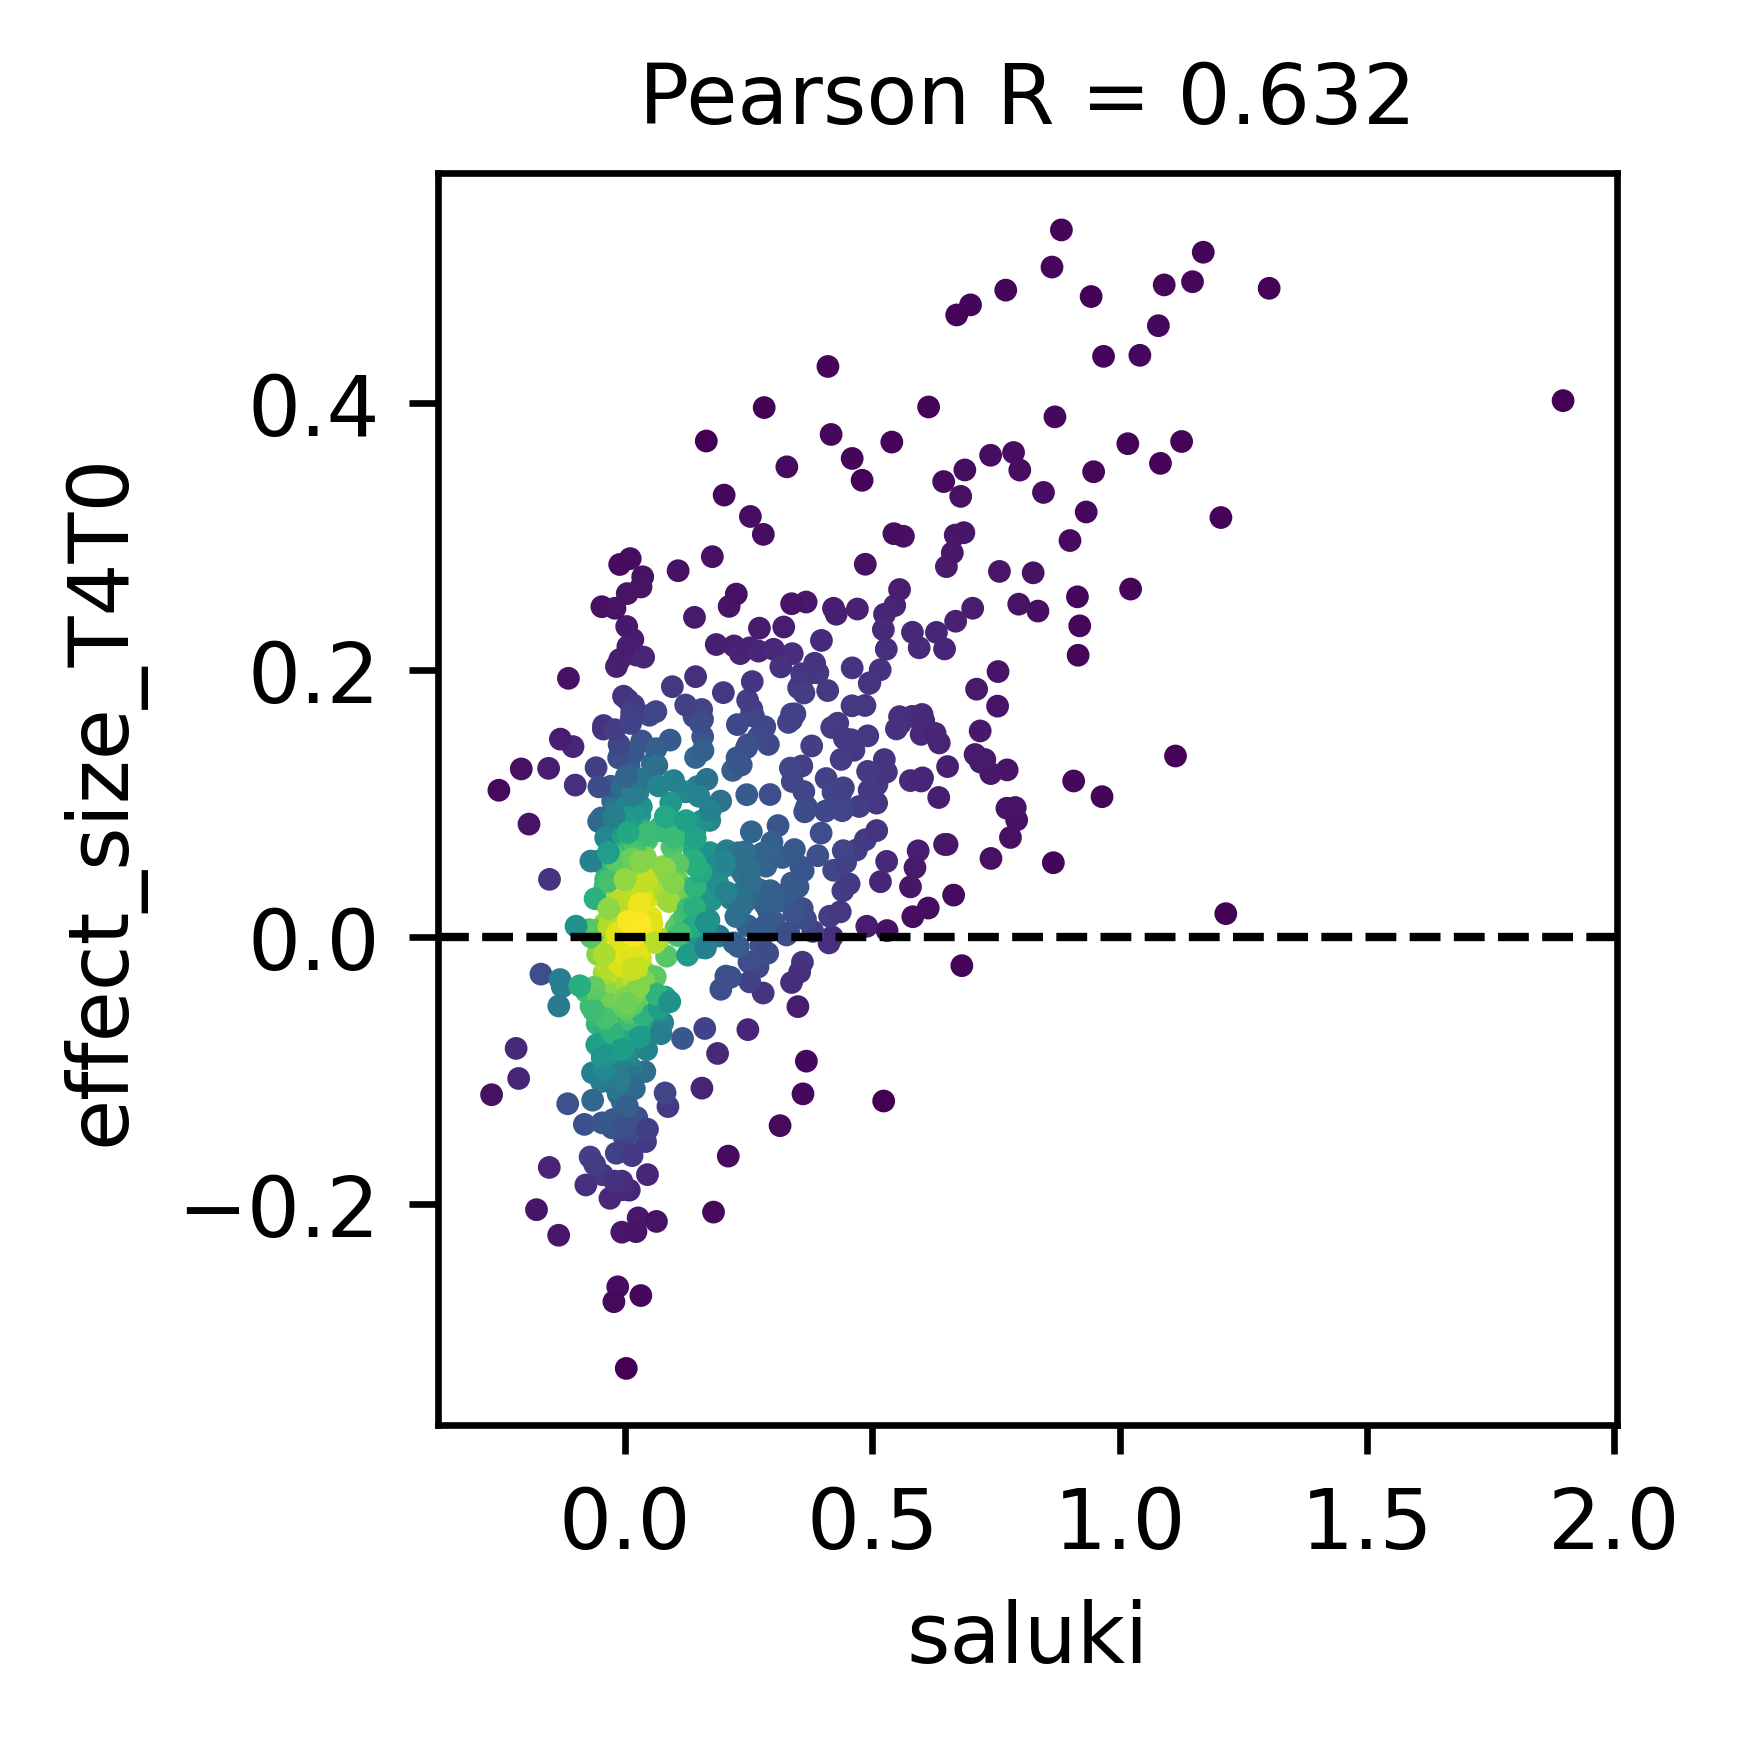

In [13]:
#Saluki

pred_col = saluki_col

sample_index = np.arange(n, dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

y_pred = np.array(df_sub[pred_col].values, dtype='float32')
y_true = np.array(df_sub[meas_col].values, dtype='float32')

rs_val = spearmanr(y_pred, y_true)[0]
rp_val = pearsonr(y_pred, y_true)[0]

vals = np.concatenate([
    np.copy(y_pred)[None, :],
    np.copy(y_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, _ = spearmanr(y_pred, y_true)
rp_val, _ = pearsonr(y_pred, y_true)

print("Saluki:")
print("Spearman R = " + str(round(rs_val, 3)))
print("Pearson R  = " + str(round(rp_val, 3)))
print("")

f = plt.figure(figsize=(3, 3), dpi=600)

plt.scatter(y_pred, y_true, s=3, c=gkernel, cmap='viridis', rasterized=True)

plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks([0.0, 0.5, 1.0, 1.5, 2.0], fontsize=10)
plt.yticks([-0.2, 0.0, 0.2, 0.4], fontsize=10)

plt.xlabel(pred_col, fontsize=10)
plt.ylabel(meas_col, fontsize=10)

plt.title("Pearson R = " + str(round(rp_val, 3)), fontsize=10)

plt.tight_layout()

if save_figs :
    plt.savefig('saluki_mpra_beas2b.png', dpi=600)
    plt.savefig('saluki_mpra_beas2b.pdf')

plt.show()


Saluki:
Spearman R = 0.577
Pearson R  = 0.646



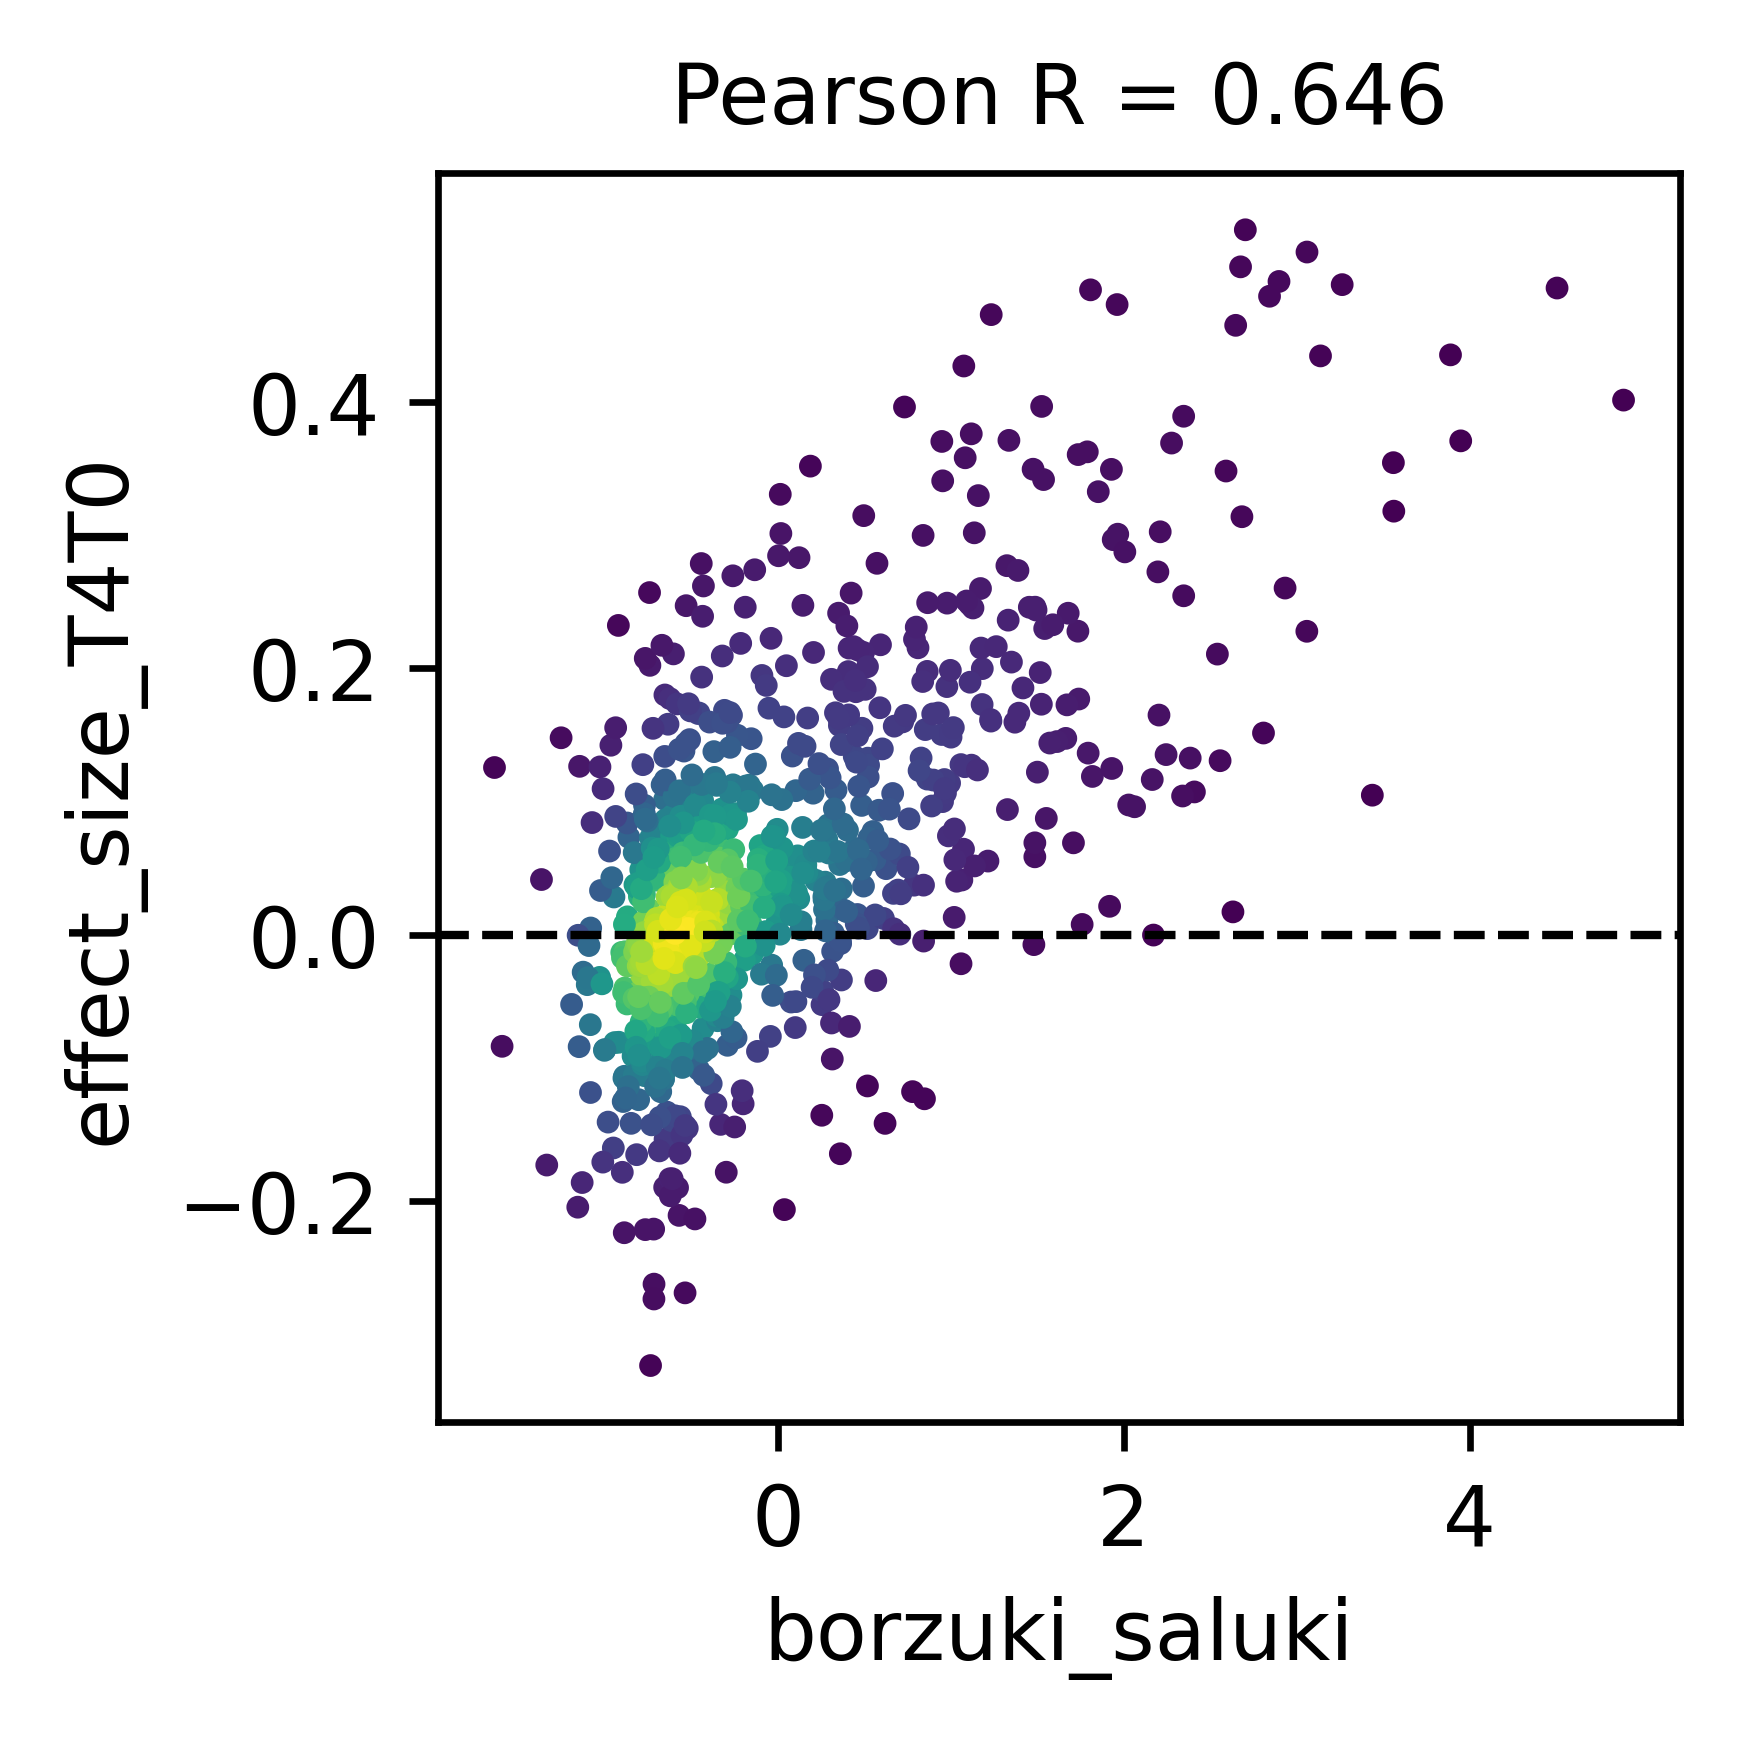

In [14]:
#Borzoi + Saluki (standardized average)

pred_col = avg_col

sample_index = np.arange(n, dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

y_pred = np.array(df_sub[pred_col].values, dtype='float32')
y_true = np.array(df_sub[meas_col].values, dtype='float32')

rs_val = spearmanr(y_pred, y_true)[0]
rp_val = pearsonr(y_pred, y_true)[0]

vals = np.concatenate([
    np.copy(y_pred)[None, :],
    np.copy(y_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, _ = spearmanr(y_pred, y_true)
rp_val, _ = pearsonr(y_pred, y_true)

print("Saluki:")
print("Spearman R = " + str(round(rs_val, 3)))
print("Pearson R  = " + str(round(rp_val, 3)))
print("")

f = plt.figure(figsize=(3, 3), dpi=600)

plt.scatter(y_pred, y_true, s=3, c=gkernel, cmap='viridis', rasterized=True)

plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks([0.0, 2.0, 4.0], fontsize=10)
plt.yticks([-0.2, 0.0, 0.2, 0.4], fontsize=10)

plt.xlabel(pred_col, fontsize=10)
plt.ylabel(meas_col, fontsize=10)

plt.title("Pearson R = " + str(round(rp_val, 3)), fontsize=10)

plt.tight_layout()

if save_figs :
    plt.savefig('borzuki_saluki_mpra_beas2b_bagging_6_reps.png', dpi=600)
    plt.savefig('borzuki_saluki_mpra_beas2b_bagging_6_reps.pdf')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


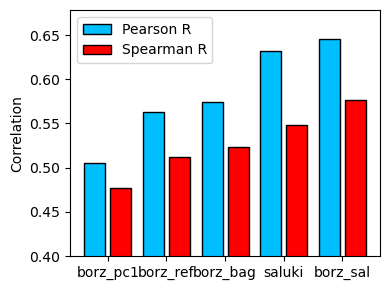

In [4]:
#Plot overview barchart of model performance metrics

model_names = [
    'borz_pc1',
    'borz_ref',
    'borz_bag',
    'saluki',
    'borz_sal',
]

corrs = np.array([
    [0.505, 0.477],
    [0.563, 0.512],
    [0.574, 0.523],
    [0.632, 0.548],
    [0.646, 0.577],
], dtype='float32')

f = plt.figure(figsize=(4, 3))

x = np.arange(len(model_names), dtype='int32')

plt.bar(x * 2.25, corrs[:, 0], color='deepskyblue', linewidth=1, edgecolor='black', label='Pearson R')
plt.bar(x * 2.25 + 1, corrs[:, 1], color='red', linewidth=1, edgecolor='black', label='Spearman R')

plt.ylim(0.40)

plt.xticks(x * 2.25 + 0.5, model_names, fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("Correlation", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.savefig('mpra_siegel_beas2b_bars_6_reps.eps')

plt.show()
